# KMNIST Tutorial
https://prob.space/competitions/kuzushiji-mnist#compe-info-nav-tutorial

In [1]:
import numpy as np
import os

class KMNISTDataLoader(object):
    """
    Example
    -------
    >>> kmnist_dl = KMNISTDataLoader()
    >>> datapath = "./data"
    >>> train_imgs, train_lbls, validation_imgs, validation_lbls = kmnist_dl.load(datapath)
    """
    def __init__(self, validation_size: float):
        """
        validation_size : float
        [0., 1.]
        ratio of validation data
        """
        self._basename_list = [
        'kmnist-train-imgs.npz',\
        'kmnist-train-labels.npz'
        ]
        self.validation_size = validation_size

    def load(self, datapath: str, random_seed: int=13) -> np.ndarray:
        filenames_list = self._make_filenames(datapath)
        data_list = [np.load(filename)['arr_0'] for filename in filenames_list]

        all_imgs, all_lbls = data_list

        # shuffle data
        np.random.seed(random_seed)
        perm_idx = np.random.permutation(len(all_imgs))
        all_imgs = all_imgs[perm_idx]
        all_lbls = all_lbls[perm_idx]

        # split train and validation
        validation_num = int(len(all_lbls)*self.validation_size)

        validation_imgs = all_imgs[:validation_num]
        validation_lbls = all_lbls[:validation_num]

        train_imgs = all_imgs[validation_num:]
        train_lbls = all_lbls[validation_num:]

        return train_imgs, train_lbls, validation_imgs, validation_lbls

    def _make_filenames(self, datapath: str) -> list:
        filenames_list = [os.path.join(datapath, basename) for basename in self._basename_list]
        return filenames_list

In [3]:
datapath = "../input"
validation_size = 0.2
train_imgs, train_lbls, validation_imgs, validation_lbls = KMNISTDataLoader(validation_size).load(datapath)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

class RandomPlotter(object):
    def __init__(self):
        self.label_char = ["お(o)", "き(ki)", "す(su)", "つ(tsu)",\
                           "な(na)", "は(ha)", "ま(ma)", "や(ya)",\
                           "れ(re)", "を(wo)"]
#         plt.rcParams['font.family'] = 'IPAPGothic'
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

    def _get_unique_labels(self, labels: np.ndarray) -> np.ndarray:
        label_unique = np.sort(np.unique(labels))
        return label_unique

    def _get_random_idx_list(self, labels: np.ndarray) -> list:
        label_unique = self._get_unique_labels(labels)

        random_idx_list = []
        for label in label_unique:
            label_indices = np.where(labels == label)[0]
            random_idx = np.random.choice(label_indices)
            random_idx_list.append(random_idx)

        return random_idx_list

    def plot(self, images: np.ndarray, labels: np.ndarray) -> None:
        """
        Parameters
        ----------
        images : np.ndarray
        train_imgs or validation_imgs

        labels : np.ndarray
        train_lbls or validation_lbls
        """
        random_idx_list = self._get_random_idx_list(labels)

        fig = plt.figure()
        for i, idx in enumerate(random_idx_list):
            ax = fig.add_subplot(2, 5, i+1)
            ax.tick_params(labelbottom=False, bottom=False)
            ax.tick_params(labelleft=False, left=False)
            img = images[idx]
            ax.imshow(img, cmap='gray')
            ax.set_title(self.label_char[i])
        fig.show()

C:\Users\PXK13\Anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


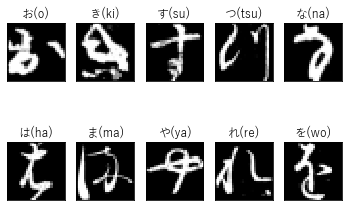

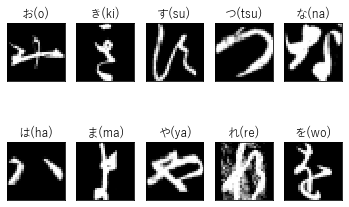

In [8]:
RandomPlotter().plot(train_imgs, train_lbls)
RandomPlotter().plot(validation_imgs, validation_lbls)

In [9]:
import numpy as np
from tensorflow.keras.utils import to_categorical

class Preprocessor(object):
    def transform(self, train_imgs, train_lbls, validation_imgs, validation_lbls):
        train_imgs, validation_imgs = self._convert_imgs_dtypes(train_imgs, validation_imgs)
        train_imgs, validation_imgs = self._convert_imgs_shape(train_imgs, validation_imgs)
        train_imgs, validation_imgs = self._normalize(train_imgs, validation_imgs)

        train_lbls, validation_lbls = self._to_categorical_labels(train_lbls, validation_lbls)
        return train_imgs, train_lbls, validation_imgs, validation_lbls

    def _convert_imgs_dtypes(self, train_imgs, validation_imgs):
        _train_imgs = train_imgs.astype('float32')
        _validation_imgs = validation_imgs.astype('float32')
        return _train_imgs, _validation_imgs

    def _convert_imgs_shape(self, train_imgs, validation_imgs):
        _train_imgs = train_imgs[:,:,:,np.newaxis]
        _validation_imgs = validation_imgs[:,:,:,np.newaxis]
        return _train_imgs, _validation_imgs

    def _normalize(self, train_imgs, validation_imgs):
        _train_imgs = train_imgs / 255.0
        _validation_imgs = validation_imgs / 255.0
        return _train_imgs, _validation_imgs

    def _to_categorical_labels(self, train_lbls, validation_lbls):
        label_num = len(np.unique(train_lbls))
        _train_lbls = to_categorical(train_lbls, label_num)
        _validation_lbls = to_categorical(validation_lbls, label_num)
        return _train_lbls, _validation_lbls

In [10]:
train_imgs, train_lbls, validation_imgs, validation_lbls = Preprocessor().transform(train_imgs, train_lbls, validation_imgs, validation_lbls)

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# dataの準備
datapath = "../input"
train_imgs, train_lbls, validation_imgs, validation_lbls = KMNISTDataLoader(validation_size).load(datapath)

train_imgs, train_lbls, validation_imgs, validation_lbls = Preprocessor().transform(train_imgs, train_lbls, validation_imgs, validation_lbls)

# modelの設定
batch_size = 128
label_num = 10
epochs = 5
input_shape = (28, 28, 1)


# model作成
model = Sequential()

model.add(layers.Conv2D(32, kernel_size=(3, 3),\
activation='relu',\
input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3),\
activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(label_num, activation='softmax'))

loss = keras.losses.categorical_crossentropy
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# modelを学習する
model.fit(train_imgs, train_lbls,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(validation_imgs, validation_lbls))

# modelを評価する
train_score = model.evaluate(train_imgs, train_lbls)
validation_score = model.evaluate(validation_imgs, validation_lbls)
print('Train loss :', train_score[0])
print('Train accuracy :', train_score[1])
print('validation loss :', validation_score[0])
print('validation accuracy :', validation_score[1])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 5s 103us/sample - loss: 0.5390 - acc: 0.8341 - val_loss: 0.1983 - val_acc: 0.9423
Epoch 2/5
48000/48000 [==============================] - 4s 76us/sample - loss: 0.1984 - acc: 0.9392 - val_loss: 0.1243 - val_acc: 0.9632
Epoch 3/5
48000/48000 [==============================] - 4s 76us/sample - loss: 0.1313 - acc: 0.9606 - val_loss: 0.0969 - val_acc: 0.9718
Epoch 4/5
48000/48000 [==============================] - 4s 76us/sample - loss: 0.1032 - acc: 0.9694 - val_loss: 0.0847 - val_acc: 0.9743
Epoch 5/5
12000/12000 [==============================] - 1s 70us/sample - loss: 0.0781 - acc: 0.9769
Train loss : 0.04191987713604855
Train accuracy : 0.98866665
validation loss : 0.0781292139555638
validation accuracy : 0.9769167


In [15]:
class MisclassifiedDataPlotter(object):
    """
    このクラスへの入力はpreprocess処理済みのデータを仮定する．
    """
    def __init__(self):
        self.label_char = ["お(o)", "き(ki)", "す(su)", "つ(tsu)",\
        "な(na)", "は(ha)", "ま(ma)", "や(ya)",\
        "れ(re)", "を(wo)"]
#         plt.rcParams['font.family'] = 'IPAPGothic'
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

    def _convert_onehot2intvec(self, labels):
        labels_int_vec = np.argmax(labels, axis=1)
        return labels_int_vec

    def _get_mixclassified_idx_list(self, labels_intvec, pred_labels_intvec):
        misclassified = labels_intvec != pred_labels_intvec
        mis_idxs_list = np.where(misclassified == True)[0]

        return mis_idxs_list

    def plot(self, images, labels, pred_labels, plot_num: int=5):
        """
        >>> images.shape
        (10000, 28, 28, 1)

        >>> labels
        array([[0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

        >>> pred_labels
        array([[2.8434190e-06, 4.1375683e-06, 9.9899501e-01, ..., 3.7393205e-05,
        2.5519948e-05, 3.0874473e-04],
        ...,
        [4.1747628e-09, 1.8852282e-07, 9.9982470e-01, ..., 1.4897050e-07,
        7.9116326e-05, 3.7392081e-05]], dtype=float32)
        """
        labels_intvec = self._convert_onehot2intvec(labels)
        pred_labels_intvec = self._convert_onehot2intvec(pred_labels)

        mis_idxs_list = self._get_mixclassified_idx_list(labels_intvec, pred_labels_intvec)
        random_idx_list = list(np.random.choice(mis_idxs_list, size=plot_num, replace=False))

        fig = plt.figure()
        for i, idx in enumerate(random_idx_list):
            ax = fig.add_subplot(1, plot_num, i+1)
            ax.tick_params(labelbottom=False, bottom=False)
            ax.tick_params(labelleft=False, left=False)
            img = images[idx].reshape((28,28)) # (28, 28, 1) -> (28, 28)
            ax.imshow(img, cmap='gray')

            actual_label = self.label_char[labels_intvec[idx]]
            pred_label = self.label_char[pred_labels_intvec[idx]]
            ax.set_title(f"{pred_label} : actual {actual_label}")
        fig.show()

C:\Users\PXK13\Anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


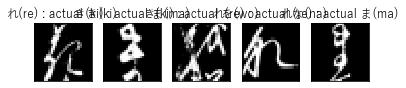

In [16]:
prediction = model.predict(validation_imgs) # このmodelは上で作成したkerasのCNNです．

mis_plotter = MisclassifiedDataPlotter()
mis_plotter.plot(validation_imgs, validation_lbls, prediction, plot_num=5)